# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import os
os.getcwd()

'/home/Hand_Gesture_Recognition'

In [2]:
%ls

Neural_Nets_Project_Starter_Code.ipynb  Project_data/  requirements.txt


In [3]:
# %cd /content/drive/MyDrive/Deep_Learning_Project/Hand_Gesture_Recognition

In [4]:
# !unzip "/content/drive/MyDrive/Deep_Learning_Project/Hand_Gesture_Recognition/Project_data.zip" -d "/content/drive/MyDrive/Deep_Learning_Project/Hand_Gesture_Recognition"

In [5]:
!pip install tensorflow==2.8.0

  Using cached tensorflow-2.8.0-cp38-cp38-manylinux2010_x86_64.whl (497.6 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached libclang-16.0.0-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_io_gcs_filesystem-0.32.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached h5py-3.8.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)


In [6]:
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [7]:
import numpy as np
import os
# from scipy.misc import imread, imresize # since scipy is not working therefore we are using PIL
from PIL import Image
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [8]:

import tensorflow as tf
import random
import numpy as np

tf.random.set_seed(30)
random.seed(30)
np.random.seed(30)


In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU(s) detected.")
else:
    print("No GPU(s) detected.")


GPU(s) detected.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [10]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
len(range(1, 30, 2))

15

In [26]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

def generator(source_path, folder_list, batch_size, debug=False, augment=False):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(1, 30, 2)  # create a list of image numbers you want to use for a particular video
    x = len(img_idx)  # WE ARE PASSING 15 IMAGES
    y, z = 120, 120

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size
        num_remaining_batches = len(t) % batch_size

        for batch in range(num_batches):  # iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z, 3))  # x is the number of images you use for each video,
            # (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5))  # batch_labels is the one hot representation of the output

            for folder in range(batch_size):  # iterate over the batch_size
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])  # read all the images in the folder

                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them in
                    # image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = Image.open(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item])
                    image = np.array(image)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw an error if the inputs in a batch have different shapes

                    size = min(image.shape[:2])
                    new_image = image[:size, :size, :]

                    resized_image = np.resize(new_image, (y, z, 3))

                    # mean = np.mean(resized_image, axis=(0, 1))
                    # std = np.std(resized_image, axis=(0, 1))
                    # normalized_image = (resized_image - mean) / std
                    
                    # normalized_image = resized_image / 255.0
                    # batch_data[folder, idx, :, :, 0] = normalized_image[:, :, 0]
                    # batch_data[folder, idx, :, :, 1] = normalized_image[:, :, 1]
                    # batch_data[folder, idx, :, :, 2] = normalized_image[:, :, 2]
                    
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder, idx, :, :, 0] = resized_image[:, :, 0]/255.0
                    batch_data[folder, idx, :, :, 1] = resized_image[:, :, 1]/255.0
                    batch_data[folder, idx, :, :, 2] = resized_image[:, :, 2]/255.0
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            if debug:
                plt.figure(figsize=(14, 14))
                for i in range(25):
                    plt.subplot(5, 5, i + 1)
                    plt.imshow(batch_data[:][np.random.randint(1, 32)][np.random.randint(1, 11)])
                plt.show()
                print(batch_data.shape)

            yield batch_data, batch_labels  # yield the batch_data and the batch_labels

        # handle the remaining images in the last batch
        if num_remaining_batches > 0:
            remaining_batch_size = num_remaining_batches
            batch_data = np.zeros((remaining_batch_size, x, y, z, 3))
            batch_labels = np.zeros((remaining_batch_size, 5))

            for folder in range(remaining_batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0])

                for idx, item in enumerate(img_idx):
                    image = Image.open(source_path + '/' + t[folder + (num_batches * batch_size)].strip().split(';')[0] + '/' + imgs[item])
                    image = np.array(image)

                    size = min(image.shape[:2])
                    new_image = image[:size, :size, :]

                    resized_image = np.resize(new_image, (y, z, 3))
                    
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder, idx, :, :, 0] = resized_image[:, :, 0]/255.0
                    batch_data[folder, idx, :, :, 1] = resized_image[:, :, 1]/255.0
                    batch_data[folder, idx, :, :, 2] = resized_image[:, :, 2]/255.0

                batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [27]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


Source path =  ./Project_data/train ; batch size = 32


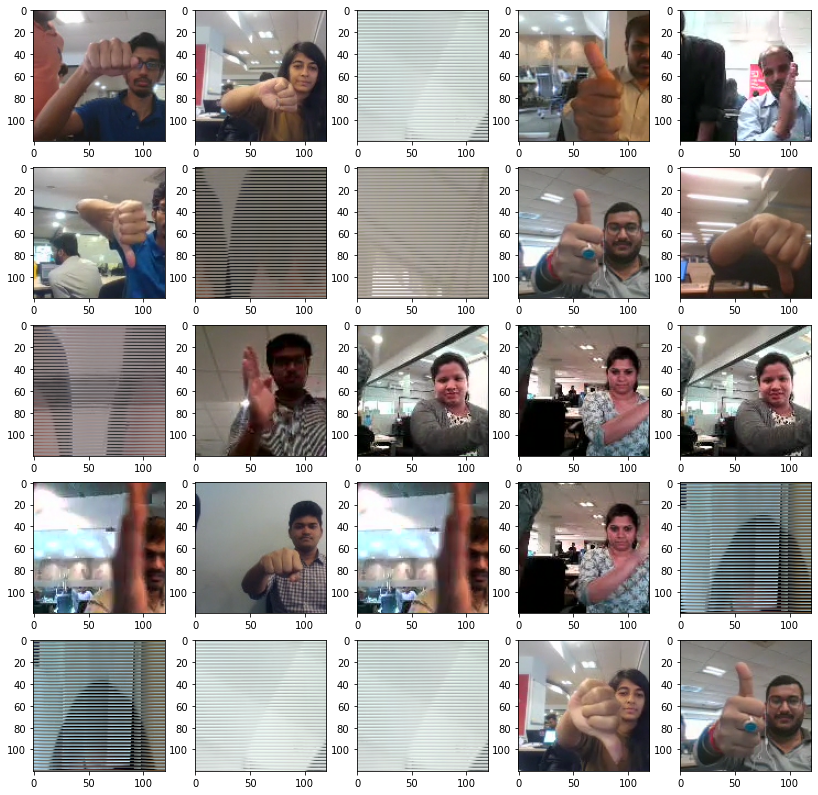

(32, 15, 120, 120, 3)


In [29]:
test_gen = generator(train_path, train_doc, batch_size, debug = True, augment=True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [15]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [16]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling3D, GlobalAveragePooling2D, LSTM, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


In [17]:
# pip install keras

In [18]:
#input shape for the st layer
input_shape = (15, 120, 120, 3)
np.random.seed(30)

## model for checking that everything is working

In [30]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Specify pool_size as a tuple of 3 values for 3D pooling

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Specify pool_size as a tuple of 3 values for 3D pooling

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [31]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 9, 118, 118, 32)   2624      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 59, 59, 32)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 256)              

# Conv3D Model 3x3 filter size (32, 64, 128, 256, 512 filters conv 3D layers + 512 dense layer having drop out 0.2

In [46]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 9, 118, 118, 32)   2624      
                                                                 
 conv3d_15 (Conv3D)          (None, 7, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 3, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 3, 58, 58, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_16 (Conv3D)          (None, 1, 56, 56, 128)   

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


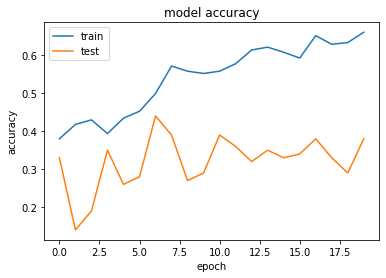

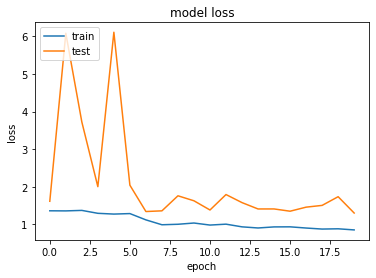

In [55]:
plot_loss_accuracy(history)

# Conv3D Model 5 by 5 filter size (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer

In [64]:
model = Sequential()

model.add(Conv3D(16, (5, 5, 5), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_38 (Conv3D)          (None, 11, 120, 120, 16)  6016      
                                                                 
 activation_34 (Activation)  (None, 11, 120, 120, 16)  0         
                                                                 
 batch_normalization_37 (Bat  (None, 11, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 5, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_39 (Conv3D)          (None, 5, 60, 60, 32)     13856     
                                                                 
 activation_35 (Activation)  (None, 5, 60, 60, 32)   

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


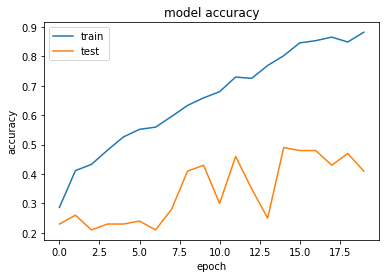

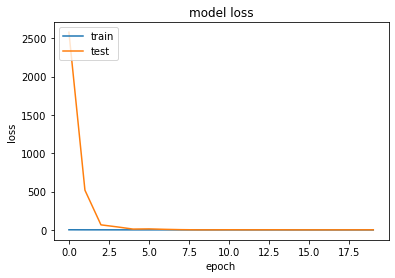

In [70]:
plot_loss_accuracy(history)

# TRANSFER LEARNING - MobileNet Conv2d + GRU with 128 dense layer

In [73]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer, input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(GRU(128))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.summary()


Number of layers in the pretrained mobilenet model:  86
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 11, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 11, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 11, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 11, 1024)         0         
 stributed)                                                      
                                                               

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


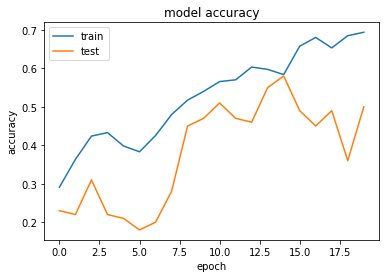

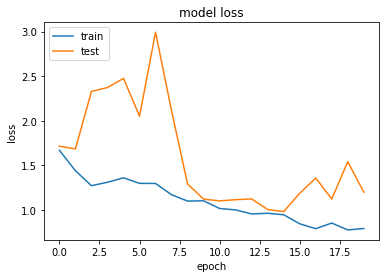

In [79]:
plot_loss_accuracy(history)

# TRANSFER LEARNING - MobileNet Conv2d + GRU with 64 dense layer

In [87]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer, input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(GRU(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.summary()


Number of layers in the pretrained mobilenet model:  86
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 11, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 11, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 11, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 11, 1024)         0         
 stributed)                                                      
                                                               

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


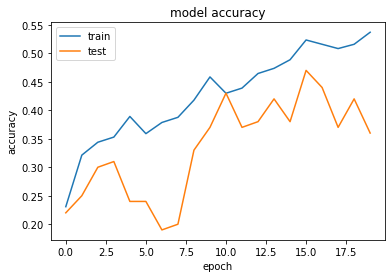

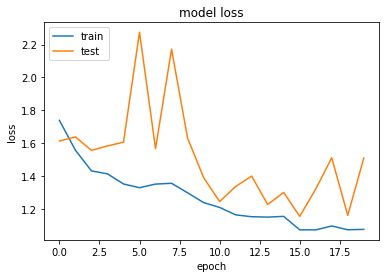

In [93]:
plot_loss_accuracy(history)

# TRANSFER LEARNING - MobileNet Conv2d + LSTM

In [94]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer, input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.summary()


Number of layers in the pretrained mobilenet model:  86
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 11, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 11, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 11, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 11, 1024)         0         
 stributed)                                                      
                                                               

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


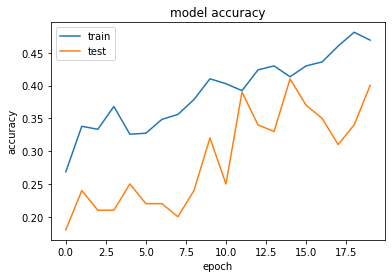

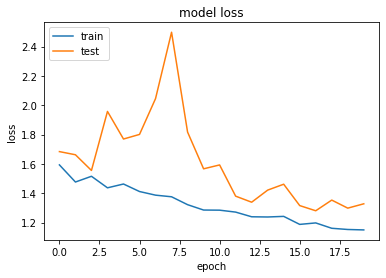

In [100]:
plot_loss_accuracy(history)

# TimeDistributed Conv2D + GRU

In [117]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_38 (TimeDi  (None, 11, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 11, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_247 (Ba  (None, 11, 59, 59, 32)   128       
 tchNormalization)                                               
                                                                 
 dropout_22 (Dropout)        (None, 11, 59, 59, 32)    0         
                                                                 
 time_distributed_40 (TimeDi  (None, 11, 57, 57, 64)   18496     
 stributed)                                          

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


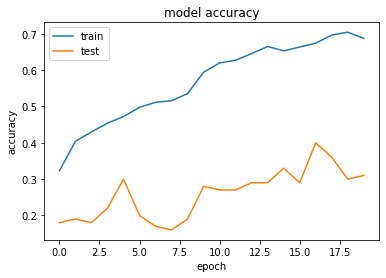

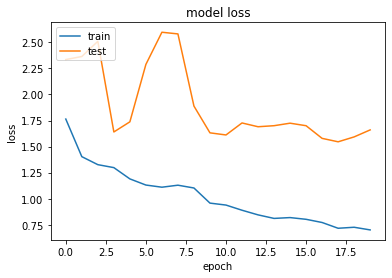

In [123]:
plot_loss_accuracy(history)

# TimeDistributed + ConvLSTM2D

In [110]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 11, 118, 118, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_243 (Ba  (None, 11, 118, 118, 8)  32        
 tchNormalization)                                               
                                                                 
 time_distributed_36 (TimeDi  (None, 11, 116, 116, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_244 (Ba  (None, 11, 116, 116, 16)  64       
 tchNormalization)                                               
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 114, 114, 8)     

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


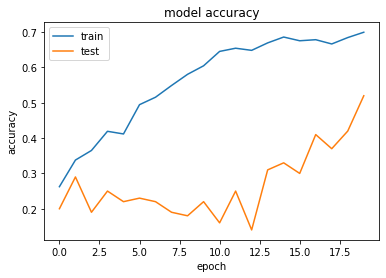

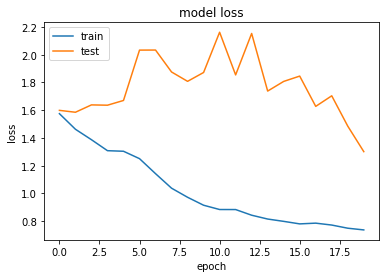

In [116]:
plot_loss_accuracy(history)

# TimeDistributed + ConvLSTM2D with conv2d (16, 32, 64, 128) + LSTM (8) + Dense (128)

In [124]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
model.add(BatchNormalization())

model.add(ConvLSTM2D(16, kernel_size=3, return_sequences=False))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 11, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 batch_normalization_251 (Ba  (None, 11, 118, 118, 16)  64       
 tchNormalization)                                               
                                                                 
 time_distributed_45 (TimeDi  (None, 11, 116, 116, 32)  4640     
 stributed)                                                      
                                                                 
 batch_normalization_252 (Ba  (None, 11, 116, 116, 32)  128      
 tchNormalization)                                               
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 114, 114, 16)    

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


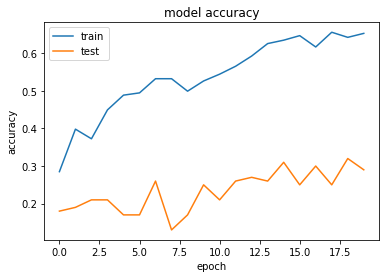

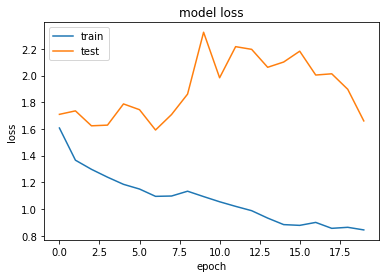

In [130]:
plot_loss_accuracy(history)

# TimeDistributed + ConvLSTM2D with conv2d (16, 32, 64, 128) + LSTM (8) + Dense (256)

In [133]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(BatchNormalization())
model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_47 (TimeDi  (None, 11, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 batch_normalization_255 (Ba  (None, 11, 118, 118, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_41 (MaxPoolin  (None, 5, 59, 59, 16)    0         
 g3D)                                                            
                                                                 
 time_distributed_48 (TimeDi  (None, 5, 57, 57, 32)    4640      
 stributed)                                                      
                                                                 
 batch_normalization_256 (Ba  (None, 5, 57, 57, 32)  

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


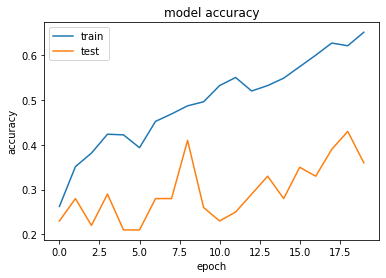

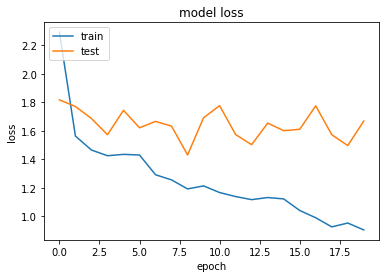

In [139]:
plot_loss_accuracy(history)

# TimeDistributed + ConvLSTM2D with conv2d (16, 32, 64, 128) + LSTM (128) + Dense (128,256)

In [141]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(BatchNormalization())
model.add(ConvLSTM2D(128, kernel_size = 3, return_sequences=False))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_55 (TimeDi  (None, 11, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 batch_normalization_269 (Ba  (None, 11, 118, 118, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_49 (MaxPoolin  (None, 5, 59, 59, 16)    0         
 g3D)                                                            
                                                                 
 time_distributed_56 (TimeDi  (None, 5, 57, 57, 32)    4640      
 stributed)                                                      
                                                                 
 batch_normalization_270 (Ba  (None, 5, 57, 57, 32)  

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


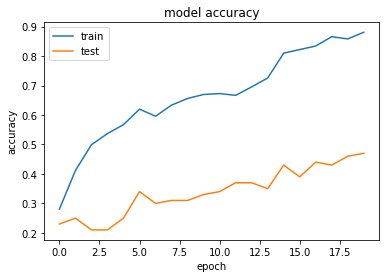

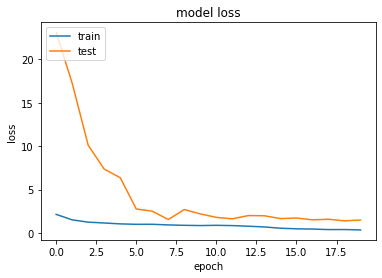

In [147]:
plot_loss_accuracy(history)

# TimeDistributed + ConvLSTM2D with conv2d (32, 64, 128, 256) + LSTM (128) + Dense (512, 256)

In [148]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu')))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(ConvLSTM2D(128, kernel_size=3, return_sequences=False))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

model.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_59 (TimeDi  (None, 11, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 batch_normalization_276 (Ba  (None, 11, 118, 118, 32)  128      
 tchNormalization)                                               
                                                                 
 max_pooling3d_53 (MaxPoolin  (None, 5, 59, 59, 32)    0         
 g3D)                                                            
                                                                 
 time_distributed_60 (TimeDi  (None, 5, 57, 57, 64)    18496     
 stributed)                                                      
                                                                 
 batch_normalization_277 (Ba  (None, 5, 57, 57, 64)  

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


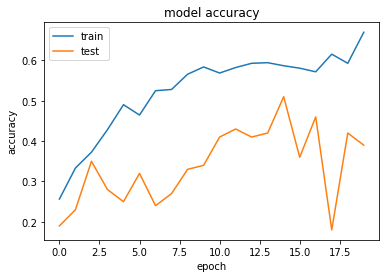

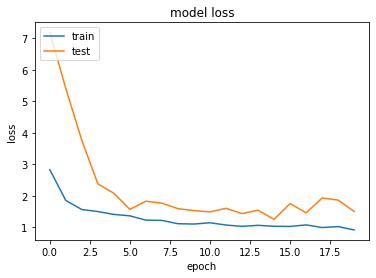

In [154]:
plot_loss_accuracy(history)

# TimeDistributed + ConvLSTM2D with conv2d (8, 16, 32, 64,) + LSTM (128) + Dense (256, 128)

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu'), input_shape=input_shape))
# model.add(BatchNormalization())

model.add(BatchNormalization())
model.add(ConvLSTM2D(128, kernel_size = 3, return_sequences=False))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


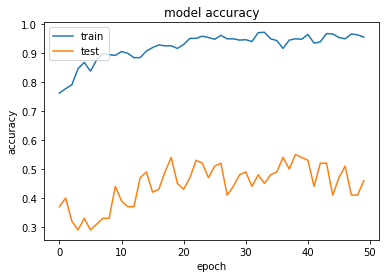

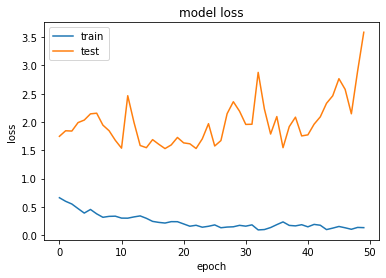

In [203]:
plot_loss_accuracy(history)

# Final model

### TimeDistributed + ConvLSTM2D with conv2d (8, 16, 32, 64) + LSTM (64) + Dense (128)

### we are selecting this model beacuse it is giving us greart accuracy as compair to other models for the final model we have trained for 50 epochs 

In [37]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

# Optimizer

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [38]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [39]:
train_generator = generator(train_path, train_doc, batch_size, augment=True)
val_generator = generator(val_path, val_doc, batch_size)

In [40]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [41]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [42]:
num_epochs = 30
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_654/3715760115.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  ./Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5245 - categorical_accuracy: 0.3077Source path =  ./Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.73034, saving model to model_init_2023-06-1413_51_51.342430/model-00001-1.52455-0.30769-1.73034-0.18000.h5
21/21 [==============================] - 75s 4s/step - loss: 1.5245 - categorical_accuracy: 0.3077 - val_loss: 1.7303 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.2810 - categorical_accuracy: 0.4193
Epoch 2: val_loss improved from 1.73034 to 1.66597, saving model to model_init_2023-06-1413_51_51.342430/model-00002-1.28102-0.41931-1.66597-0.16000.h5
21/21 [==============================] - 70s 3s/step - loss: 1.2810 - categorical_accuracy: 0.4193 - val_loss: 1.6660 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 3/30
21/21 [==============================] 

In [ ]:
num_epochs = 50  # Update the number of epochs to include the additional 20 epochs
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=30)
